# Paraphrase-Detection using Siamese Network
Paraphrase detection is the task of examining two text entities (ex. sentence) and determining whether they have the same meaning. In order to obtain high accuracy on this task, thorough syntactic and semantic analysis of the two text entities is required.

## What is Paraphrase?
In simple words, paraphrase is just an alternative representation of the same meaning.

![text_similarity.png](text_similarity.png)

## Quora Question Pairs Dataset
There are over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.

We can download dataset from [Quora Question Pairs Dataset](https://www.kaggle.com/quora/question-pairs-dataset)

In [0]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import string
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate,Subtract,Multiply,Concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,MaxPooling2D,Bidirectional,Flatten,Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
import spacy
sp = spacy.load('en_core_web_sm')
# import nltk
# nltk.download("punkt")

Using TensorFlow backend.


## Read Dataset

In [0]:
project_path = 'paraphrase_detection/'

In [0]:
data = pd.read_csv(project_path+"questions.csv",nrows=10000)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Preprocess Data

In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
def clean_question(text):
    doc = sp(text)
    # tokenize
    # text = text.split()
    # Lemmatization
    text = [token.lemma_ for token in doc]
    # convert to lower case
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [w.translate(table) for w in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1]
    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # store as string
    return ' '.join(text)

In [0]:
data["question1"] = data["question1"].apply(lambda x:clean_question(x))
data["question2"] = data["question2"].apply(lambda x:clean_question(x))

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,1,3,4,what be the story of kohinoor koh noor diamond,what would happen if the indian government ste...,0
2,2,5,6,how can pron increase the speed of pron intern...,how can internet speed be increase by hack thr...,0
3,3,7,8,why be pron mentally very lonely how can pron ...,find the remainder when be divide by,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


## Feature Extraction

In [0]:
# fit a tokenizer with questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["question1"].values+data["question2"].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 17723


In [0]:
# create sequences
max_len = 25
q1_texts_seq = tokenizer.texts_to_sequences(data["question1"].values)
q2_texts_seq = tokenizer.texts_to_sequences(data["question2"].values)

q1_texts_seq = pad_sequences(q1_texts_seq,maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq,maxlen=max_len)

In [0]:
if os.path.isdir('glove') == False:
    os.mkdir('glove')

glove_dir = "datasets/"
from zipfile import ZipFile
with ZipFile(glove_dir+'glove.zip', 'r') as z:
  z.extractall("glove")

In [0]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join("glove/", 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)
y = data["is_duplicate"].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Get Question 1/2  train and test features
q1_X_train = X_train[:,0]
q2_X_train = X_train[:,1]

q1_X_test = X_test[:,0]
q2_X_test = X_test[:,1]

## Build Model

Paraphrase Detection using **Siamese Network** model

In [0]:
## Define custon metrics
def f1_score(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0 or c2 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score


def precision(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    if c2 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    return precision


def recall(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    return recall

In [0]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [0]:
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
# siamese model
def create_model(input_shape,embeddings_dim, embeddings_matrix, vocab_size,
                      max_seq_length, trainable_embeddings,
                      lstm_hidden_units):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)


    common_embed = Embedding(vocab_size, embeddings_dim, weights=[embeddings_matrix], input_length=max_seq_length, trainable=trainable_embeddings) 
    lstm_1 = common_embed(input_1)
    lstm_2 = common_embed(input_2)


    common_lstm = LSTM(lstm_hidden_units,return_sequences=True, activation="relu")
    vector_1 = common_lstm(lstm_1)
    vector_1 = Flatten()(vector_1)

    vector_2 = common_lstm(lstm_2)
    vector_2 = Flatten()(vector_2)

    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
        
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
        
    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=['accuracy', auroc,precision, recall, f1_score])

    return model

In [0]:
trainable_embeddings = False
lstm_hidden_units = 50
input_shape = (max_len,)
model = create_model(input_shape,
                      embedding_dim, embedding_matrix, vocab_size,
                      max_len, trainable_embeddings,lstm_hidden_units)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
___________________

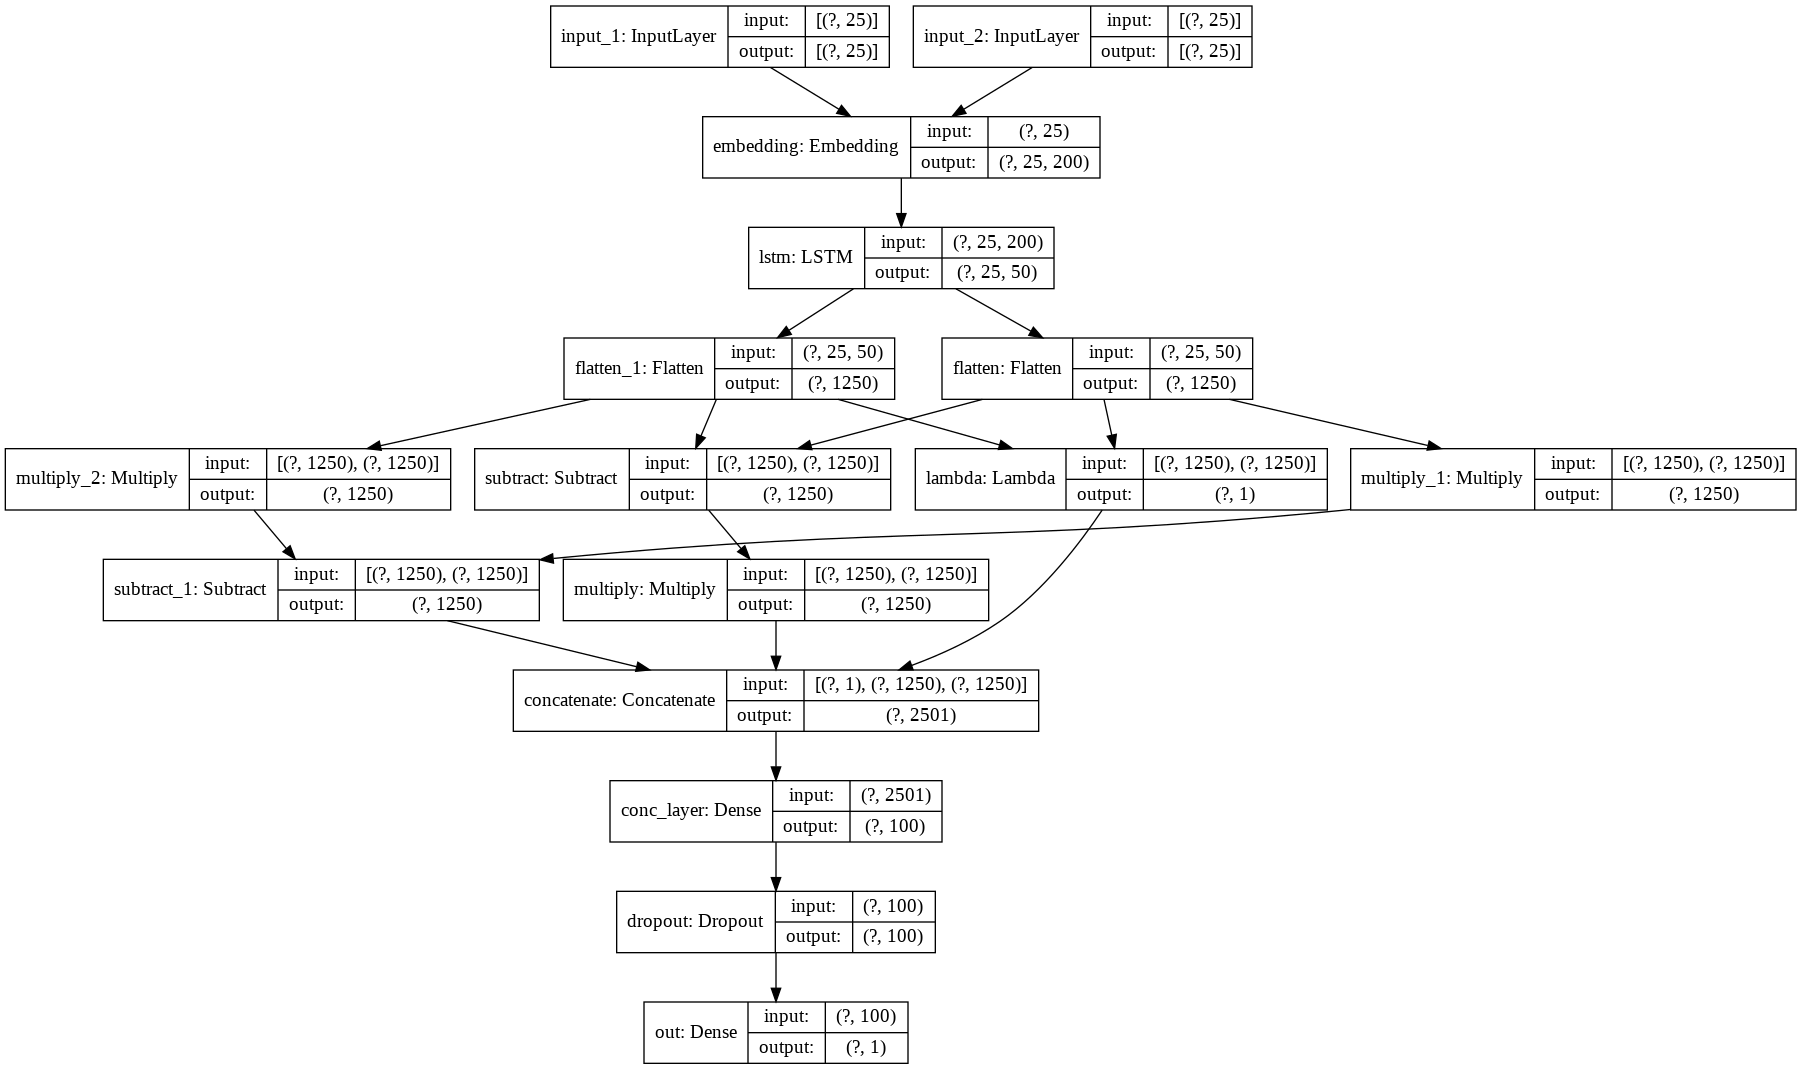

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

## Train the model

In [0]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = project_path+'model_paraprase_detection_siamese.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint,reduce_alpha] 

In [0]:
epochs = 30
batch_size = 64
history = model.fit(x=[q1_X_train, q2_X_train],
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([q1_X_test, q2_X_test], y_test),callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
7936/8000 [============================>.] - ETA: 0s - loss: 0.6081 - acc: 0.6309 - auroc: 0.6962 - precision: 0.2933 - recall: 0.0689 - f1_score: 0.0972
Epoch 00001: val_loss improved from inf to 0.59302, saving model to /content/drive/My Drive/DLCP/openwork/paraphrase_detection/model_paraprase_detection_siamese.h5
8000/8000 [==============================] - 12s 1ms/sample - loss: 0.6075 - acc: 0.6321 - auroc: 0.6963 - precision: 0.2957 - recall: 0.0713 - f1_score: 0.1001 - val_loss: 0.5930 - val_acc: 0.6515 - val_auroc: 0.7282 - val_precision: 0.6035 - val_recall: 0.1716 - val_f1_score: 0.2598
Epoch 2/30
7936/8000 [============================>.] - ETA: 0s - loss: 0.5451 - acc: 0.7004 - auroc: 0.7770 - precision: 0.6344 - recall: 0.4607 - f1_score: 0.5133
Epoch 00002: val_loss improved from 0.59302 to 0.57672, saving model to /content/drive/My Drive/DLCP/openwork/paraphrase_detection/model_paraprase_detection_siamese.h5
8000

In [0]:
# filepath = project_path+'model_paraprase_detection_siamese.h5'
# model.save_weights(filepath)

## Training Summary

In [0]:
# list all data in history
print("All data in history: ", history.history.keys())

All data in history:  dict_keys(['loss', 'acc', 'auroc', 'precision', 'recall', 'f1_score', 'val_loss', 'val_acc', 'val_auroc', 'val_precision', 'val_recall', 'val_f1_score', 'lr'])


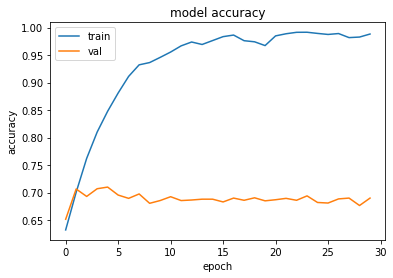

In [0]:
# summarize history for accuracy
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

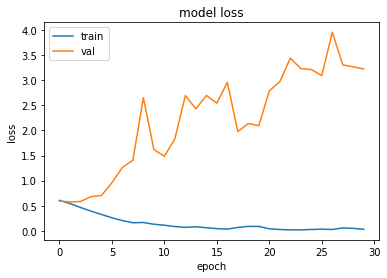

In [0]:
# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

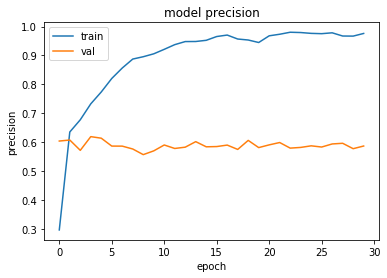

In [0]:
# summarize history for precision
fig = plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_precision.png')

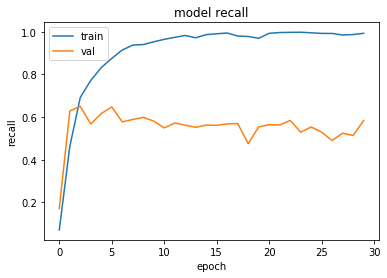

In [0]:
# summarize history for recall
fig = plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_recall.png')

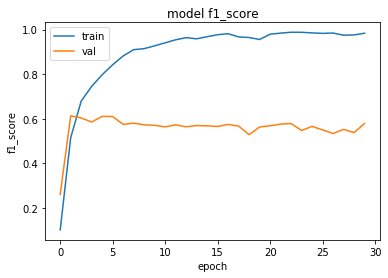

In [0]:
# summarize history for f1 score
fig = plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_f1_score.png')

## Test the model

In [0]:
print('Testing Data Metrics:')
loss, accuracy, auroc, precision, recall, f1_score = model.evaluate([q1_X_test, q2_X_test], y_test)
print('')
print('loss      = {0:.4f}'.format(loss))
print('accuracy  = {0:.4f}'.format(accuracy))
print('auroc  = {0:.4f}'.format(auroc))
print('precision = {0:.4f}'.format(precision))
print('recall    = {0:.4f}'.format(recall))
print('F1         = {0:.4f}'.format(f1_score))

Testing Data Metrics:
2000/2000 [==============================] - 2s 975us/sample - loss: 3.2213 - acc: 0.6900 - auroc: 0.7262 - precision: 0.5834 - recall: 0.5640 - f1_score: 0.5644

loss      = 3.2213
accuracy  = 0.6900
auroc  = 0.7262
precision = 0.5834
recall    = 0.5640
F1         = 0.5644
